In [5]:
import os
from dotenv import load_dotenv
import nibabel as nib
from nibabel.orientations import aff2axcodes
import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm

from utils.registration import nifit_info, correct4registration, slice2chunk_align
from utils.preproc import FUSCleaner

from utils.glm import run_glm_analysis
from nilearn.glm.contrasts import compute_contrast
from scipy.ndimage import affine_transform
import SimpleITK as sitk

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from joblib import Parallel, delayed

In [6]:
load_dotenv()
base_dir = os.getenv('BASE_DIR')
task_dir = os.path.join(base_dir, 'task_data')
register_dir = os.path.join(base_dir, 'slice2chunk_grouper', '061824_1-5')
register_dir2 = os.path.join(base_dir, 'slice2chunk_grouper', '060324_8-5')
figure_dir = os.path.join(base_dir, 'figures')

os.makedirs(figure_dir, exist_ok=True)

# Registration

In [7]:
def transform_affine(affine_matrix):
    # Make a copy to avoid modifying the original matrix
    transformed_matrix = affine_matrix.copy()
    
    # Flip the signs of the first and third diagonal elements
    transformed_matrix[0, 0] = -affine_matrix[0, 0]
    transformed_matrix[2, 2] = -affine_matrix[2, 2]
    
    # Set the translation components (last column) to 0
    transformed_matrix[0, 3] = 0
    transformed_matrix[2, 3] = 0
    
    return transformed_matrix

In [8]:
raw_file = os.path.join(task_dir, 'Grouper_audiocue_060324_2D.nii')
raw_file2 = os.path.join(task_dir, 'Grouper_audiocue_060324_2D.nii.gz')

raw_image = nib.load(raw_file)
raw_image2 = nib.load(raw_file2)

aff2axcodes(raw_image.affine), aff2axcodes(raw_image2.affine)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


(('L', 'A', 'S'), ('R', 'A', 'I'))

In [9]:
def load_nifti_image(file_path: str):
    """Loads a NIfTI image and returns its data array and affine matrix."""
    img = nib.load(file_path)
    data = img.get_fdata()
    affine = img.affine
    return data, affine, img.header


def process_and_save_image(first_img_path: str, second_img_path: str, output_path: str):
    """Loads the images, applies affine corrections, flips the data, and saves the corrected image."""
    # Load the first image (4D) and the second image (corrected slice)
    first_data, _, _ = load_nifti_image(first_img_path)
    _, second_affine, second_header = load_nifti_image(second_img_path)

    corrected_affine = second_affine.copy()
    corrected_affine[[0, 1]] = corrected_affine[[1, 0]]

    print("Corrected Affine:\n", corrected_affine)
    print(aff2axcodes(corrected_affine))
    
    # reflect z to be positive
    transform_matrix = np.array([[1, 0, 0, 0],
                                [0, 1, 0, 0],
                                [0, 0, -1, 0],
                                [0, 0, 0, 1]])

    transformed_affine = corrected_affine @ transform_matrix

    print(transformed_affine)

    flipped_data = np.flip(first_data, axis=2)

    new_img = nib.Nifti1Image(flipped_data, transformed_affine, second_header)

    nib.save(new_img, output_path)
    print(f"Corrected image saved to {output_path}")

In [10]:
# correct 2D x timepoints for later analysis
output_path = os.path.join(register_dir2, 'Grouper_audiocue_060324_2D_timepoints_corrected.nii.gz')
process_and_save_image(raw_file, raw_file2, output_path)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Corrected Affine:
 [[ 0.          0.40000001  0.         -0.        ]
 [ 0.11        0.          0.         -0.        ]
 [ 0.          0.         -0.09856     0.        ]
 [ 0.          0.          0.          1.        ]]
('A', 'R', 'I')
[[0.         0.40000001 0.         0.        ]
 [0.11       0.         0.         0.        ]
 [0.         0.         0.09856    0.        ]
 [0.         0.         0.         1.        ]]
Corrected image saved to /om2/scratch/tmp/yibei/fusi/slice2chunk_grouper/060324_8-5/Grouper_audiocue_060324_2D_timepoints_corrected.nii.gz


# social trial (0618-1.5)

In [152]:
cortical_atlas_file = os.path.join(base_dir, "atlas", "atlas_MBM_cortex_vH.nii.gz")
# subcortical_atlas_file = os.path.join(base_dir, "atlas", "SAMv1.0.nii.gz")
subcortical_atlas_file = os.path.join(base_dir, "atlas", "atlas_MBM_subcortical_beta.nii.gz")

cortical_atlas = nib.load(cortical_atlas_file).get_fdata()
subcortical_atlas = nib.load(subcortical_atlas_file).get_fdata()

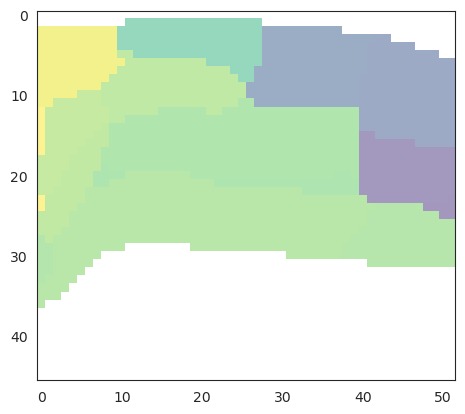

In [154]:
plt.imshow(np.rot90(np.max(cortical_atlas[79:81, 80:132, 72:118], axis=0)), cmap=new_cmap, alpha=0.5)
plt.show()

In [120]:
np.unique(cortical_atlas[0, :, :])

array([  0.,   1.,   2.,   5.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,
        18.,  20.,  25.,  28.,  30.,  67.,  79.,  80.,  81.,  82.,  83.,
        85.,  86.,  87.,  89.,  90.,  91., 101., 102., 103., 105.])

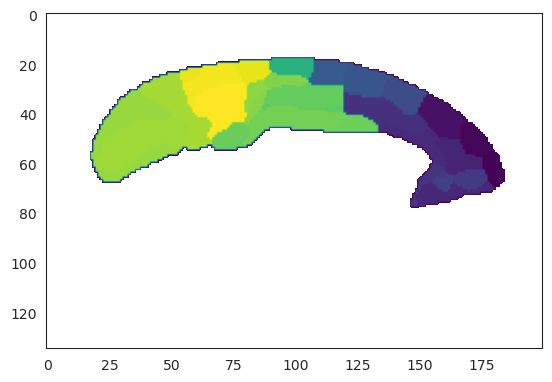

In [151]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap where 0 is white
cmap = plt.get_cmap('viridis', 256)  # 'viridis' or any colormap of your choice
new_cmap = cmap(np.linspace(0, 1, 256))
new_cmap[0, :] = np.array([1, 1, 1, 1])  # Set the first color (corresponding to 0) to white
new_cmap = ListedColormap(new_cmap)
plt.imshow(np.rot90(cortical_atlas[1, :, :]), cmap=new_cmap)
plt.show()

In [29]:
raw_ts_file = os.path.join(task_dir, '0618_livemarmoset_plane1.5.nii')
transformed_ts_file = os.path.join(task_dir,'grouper_livemarmoset_0618_ts_transformed.npy')

raw_ts = nib.load(raw_ts_file).get_fdata()
transformed_ts = np.load(transformed_ts_file)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


In [45]:
transformed_ts.shape, raw_ts.shape

((2, 200, 135, 4500), (128, 1, 143, 4500))

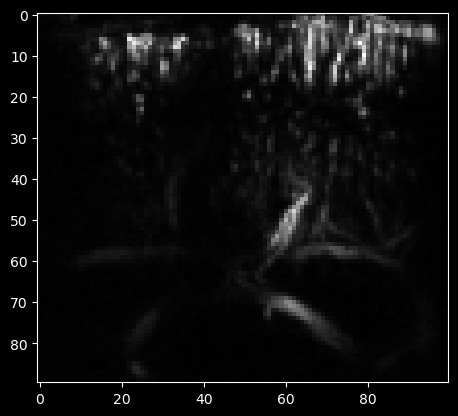

In [57]:
plt.imshow(raw_ts[10:110, 0, 10:100, 0].T, cmap='gray')

<Axes: >

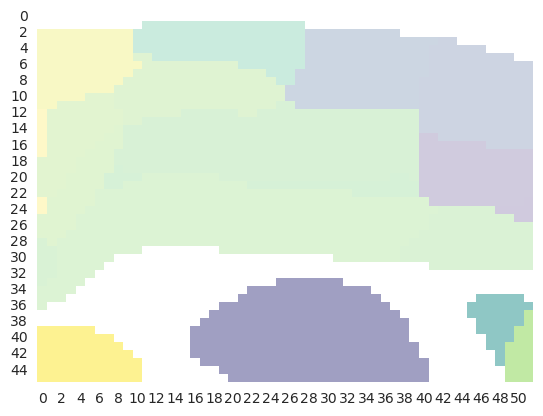

In [131]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from skimage.measure import find_contours
from scipy.ndimage import gaussian_filter

# Set white theme
sns.set_style("white")
# Example cortical data (replace with actual cortical atlas data)
cortical_data = np.rot90(np.max(cortical_atlas[:, 80:132, 72:118], axis=0))
subcortical_data = np.rot90(np.max(subcortical_atlas[:, 80:132, 72:118], axis=0))
transform_ts_data = np.rot90(np.max(transformed_ts[:, 80:132, 72:118, 0], axis=0))

sns.heatmap(cortical_data, cmap=new_cmap, cbar=False, alpha=0.5)
sns.heatmap(subcortical_data, cmap=new_cmap, cbar=False, alpha=0.5)
# sns.heatmap(transform_ts_data, cmap="viridis", cbar=False, alpha=0.5)

In [142]:
def extract_roi_ts(atlas_data, brain_data):
    # Ensure atlas and brain_data have matching spatial dimensions
    if atlas_data.shape != brain_data.shape[:2]:
        raise ValueError("Atlas and brain data spatial dimensions do not match")

    roi_values = np.unique(atlas_data)
    roi_values = roi_values[roi_values > 0]  # Ignore background (0 values)
    
    roi_time_series = {}

    for roi in roi_values:
        roi_mask = atlas_data == roi
        # Apply mask only on the first three spatial dimensions of brain_data
        roi_data = brain_data[roi_mask, :]  # Select voxels within the ROI, keeping time dimension
        roi_avg_time_series = np.mean(roi_data, axis=0)  # Average across voxels
        roi_time_series[str(int(roi))] = roi_avg_time_series
    
    return roi_time_series

In [181]:
def plot_roi_time_series(roi_time_series):
    plt.figure(figsize=(10, 6))  # Set figure size

    # Loop through the ROIs and plot their time series
    for roi, time_series in roi_time_series.items():
        plt.plot(time_series, label=f'ROI {roi}')  # Plot each ROI's time series

    # Add labels and title
    # plt.xlabel('Time Points')
    # plt.ylabel('Signal Intensity')
    # plt.title('Time Series for Each ROI')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)  # Move the legend outside the plot
    
    plt.tight_layout()  # Adjust the layout so the legend fits
    plt.show()

def plot_roi_time_series_heatmap(roi_time_series, atlas_labels, vmin=None, vmax=None):
    """
    Plots ROI time series as a heatmap, where x-axis is time and y-axis is ROI.
    
    Parameters:
    - roi_time_series: dict, keys are ROI labels and values are 1D time series arrays.
    """
    # Sort the ROIs by their labels (optional, for better visualization)
    sorted_rois = sorted(roi_time_series.keys())
    labels = [atlas_labels[roi] for roi in sorted_rois]
    
    # Stack the time series data into a 2D array (ROI x Time)
    roi_matrix = np.array([roi_time_series[roi] for roi in sorted_rois])
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))  # Adjust the figure size
    sns.heatmap(roi_matrix, cmap="viridis", cbar=True, yticklabels=labels, vmin=vmin, vmax=vmax)
    # rotate the y-axis labels
    plt.yticks(rotation=0)
    # Add labels and title
    plt.xlabel('Time Points')
    plt.ylabel('ROI')
    plt.title('ROI Time Series Heatmap')
    
    plt.show()

In [161]:
from utils.preproc import FUSCleaner

cleaner = FUSCleaner(detrend=False, standardize=True, low_pass=0.8, high_pass=0.01, fs=2.5, sigma=0.5)

cleaned_transformed_data = cleaner.clean(transformed_ts)

In [185]:
from scipy.signal import resample

def resample2sec(data):

    n_timepoints = cleaned_transformed_data.shape[-1]
    TR = 2.5  
    new_TR = 1.0  

    duration_in_seconds = n_timepoints / TR
    new_n_timepoints = int(duration_in_seconds * new_TR)

    resampled_data = resample(data, new_n_timepoints, axis=-1)

    # Print out new shape of the data
    print("Original shape:", data.shape)
    print("Resampled shape:", resampled_data.shape)
    return resampled_data


In [186]:
resampled_raw = resample2sec(transformed_ts)
resampled_cleaned = resample2sec(cleaned_transformed_data)

Original shape: (2, 200, 135, 4500)
Resampled shape: (2, 200, 135, 1800)
Original shape: (2, 200, 135, 4500)
Resampled shape: (2, 200, 135, 1800)


In [187]:
cortical_atlas_data = np.max(cortical_atlas[79:81, 80:132, 72:118], axis=0)
subcortical_atlas_data = np.max(subcortical_atlas[79:81, 80:132, 72:118], axis=0)
brain_data = np.max(resampled_raw[:, 80:132, 72:118, :], axis=0)
brain_data_cleaned = np.max(resampled_cleaned[:, 80:132, 72:118, :], axis=0)

cortical_ts = extract_roi_ts(cortical_atlas_data, brain_data)
subcortical_ts = extract_roi_ts(subcortical_atlas_data, brain_data)

cortical_ts_cleaned = extract_roi_ts(cortical_atlas_data, brain_data_cleaned)
subcortical_ts_cleaned = extract_roi_ts(subcortical_atlas_data, brain_data_cleaned)

In [172]:
np.unique(subcortical_atlas_data), np.unique(cortical_atlas_data)

(array([ 0.,  3.,  8., 13., 16.]),
 array([  0.,  14.,  15.,  28.,  30.,  67.,  79.,  80.,  81.,  82.,  83.,
         85.,  86.,  87., 101., 105.]))

In [173]:
cortical_atlas_labels = {
    "14": "A24b",
    "15": "A24cd",
    "28": "A4L",
    "30": "S1D",
    "67": "PEa",
    "79": "A23a",
    "80": "A23b",
    "81": "A23V",
    "82": "A29M",
    "83": "A30",
    "85": "A31",
    "86": "PGMa",
    "87": "PGMb",
    "101": "V6R",
    "105": "A19M",
}

subcortical_atlas_labels = {
    "3": "Thalamus",
    "8": "Caudate",
    "13": "Septum",
    "16": "Superior colliculus",
}

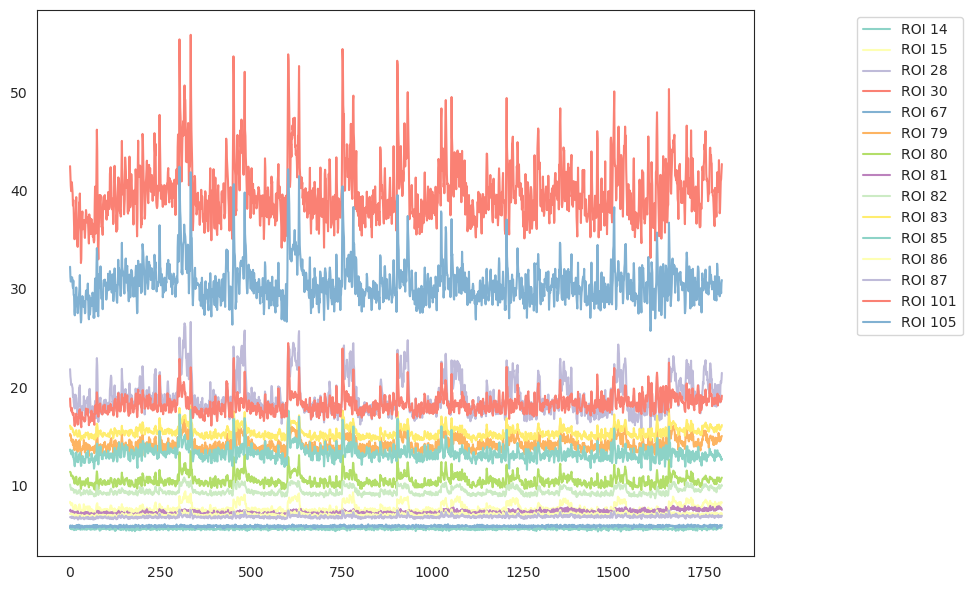

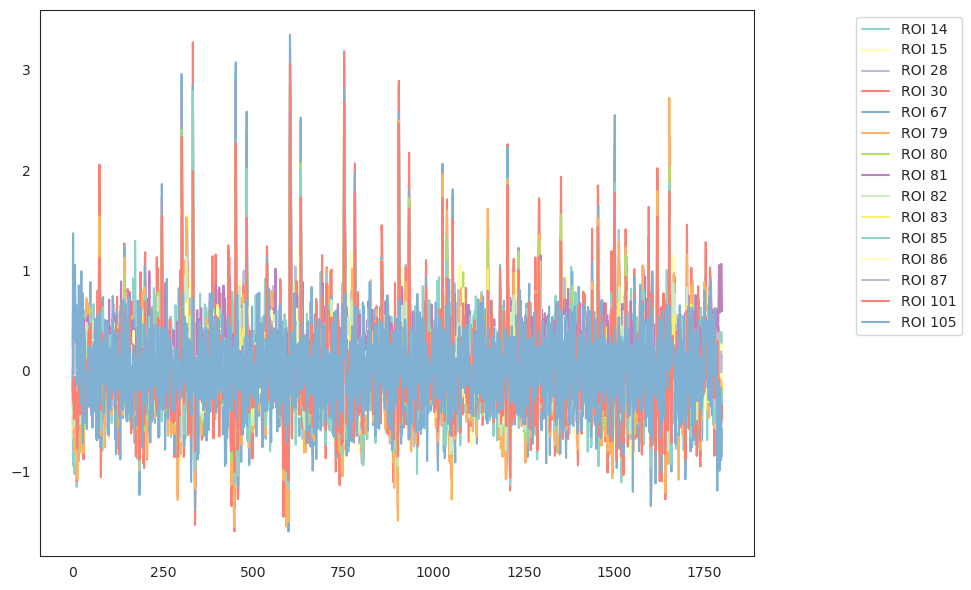

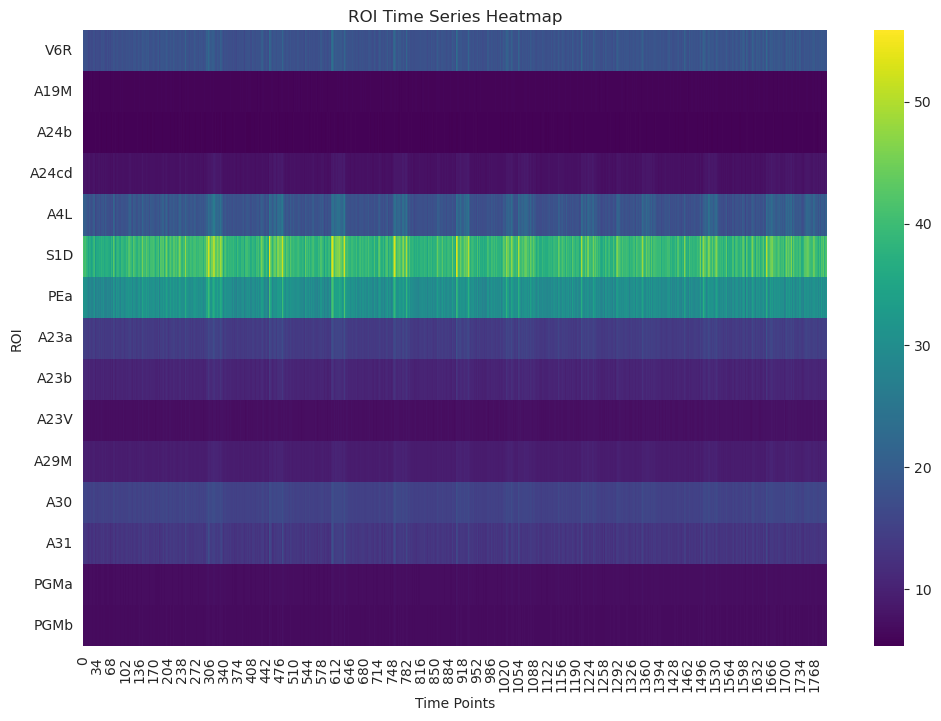

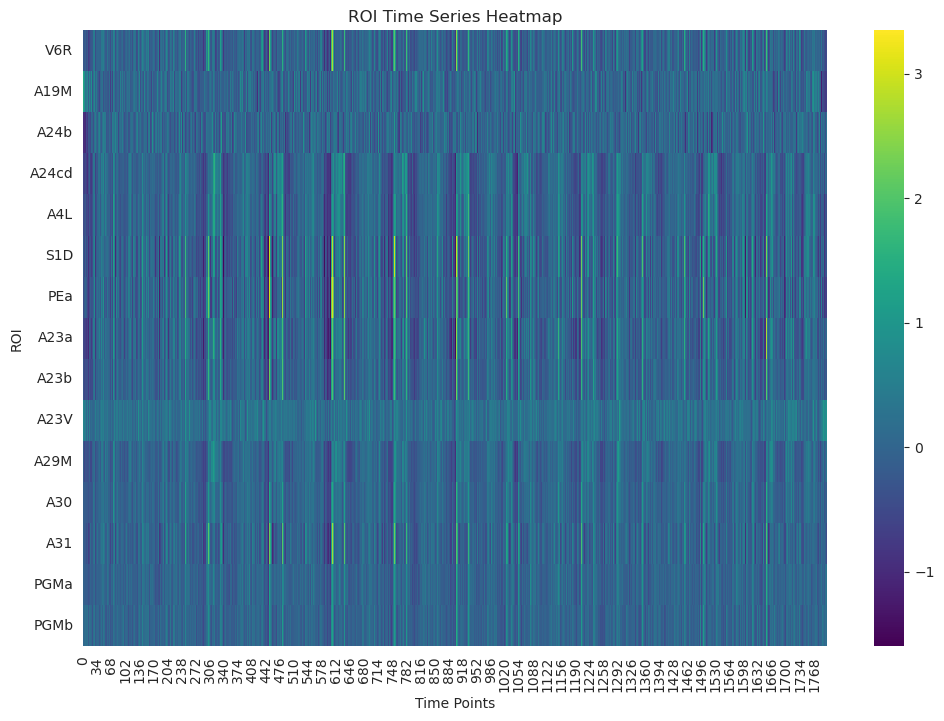

In [224]:
plot_roi_time_series(cortical_ts)
plot_roi_time_series(cortical_ts_cleaned)
plot_roi_time_series_heatmap(cortical_ts, cortical_atlas_labels)
plot_roi_time_series_heatmap(cortical_ts_cleaned, cortical_atlas_labels)

# PSTH

In [229]:
def extract_trial_data(task_data, event_onsets, pre_sec=10, post_sec=40, sampling_rate=1):
    """
    Extract trial data from task data based on event frames.

    Parameters:
    - task_data: 2D numpy array of shape (n_region, n_frame) representing the time series data
    - event_onsets: List of event frames (onsets) in terms of frame indices
    - pre_sec: Number of seconds to include before onset (default=10)
    - post_sec: Number of seconds to include after onset (default=40)
    - sampling_rate: Sampling rate in Hz (default=2.5 Hz)

    Returns:
    - trial_data: 3D numpy array of shape (n_region, n_frame_per_trial, n_trial)
    """
    n_region, n_frame = task_data.shape

    # Convert pre_sec and post_sec to frame counts
    pre_frames = int(pre_sec * sampling_rate)
    post_frames = int(post_sec * sampling_rate)

    # Define the number of frames per trial
    length_per_trial = pre_frames + post_frames  # Total frames for each trial

    # Initialize an array to store the trial data
    n_trial = len(event_onsets)
    trial_data = np.zeros((n_region, length_per_trial, n_trial))

    # Extract trial data for each event onset
    for i, onset in enumerate(event_onsets):
        start_idx = onset - pre_frames
        end_idx = onset + post_frames

        # Check if the trial window is within the valid range
        if start_idx >= 0 and end_idx <= n_frame:
            trial_data[:, :, i] = task_data[:, start_idx:end_idx]
        else:
            raise ValueError(f"Trial window for event {i} is out of bounds. Start frame: {start_idx}, End frame: {end_idx}")

    return trial_data

def compute_psth(trial_data, baseline_length=10):
    """
    Compute the peri-stimulus time histogram (PSTH) by normalizing each trial to its baseline.
    
    Parameters:
    - trial_data: 3D numpy array of shape (n_region, n_frame_per_trial, n_trial)
    - baseline_length: Number of frames to use for baseline (default=10 frames)

    Returns:
    - normalized_data: 3D numpy array of normalized trial data
    """
    n_region, n_frame_per_trial, n_trial = trial_data.shape

    # Initialize an array to store the normalized data
    normalized_data = np.zeros_like(trial_data)

    # Normalize each trial to its pre-event baseline using percent signal change
    for trial in range(n_trial):
        baseline = np.mean(trial_data[:, :baseline_length, trial], axis=1, keepdims=True)

        # Prevent division by zero
        safe_baseline = np.where(baseline == 0, 1, baseline) 

        # Normalize trial data relative to baseline
        normalized_data[:, :, trial] = (trial_data[:, :, trial] - baseline) / safe_baseline

    return normalized_data


In [230]:
event_sec = [300, 450, 600, 750, 900, 1050, 1200, 1350, 1500, 1650]
event_duration = 30
cortical_ts_cleaned_array = np.array(list(cortical_ts_cleaned.values()))
cortical_trial_data = extract_trial_data(cortical_ts_cleaned_array, event_sec)
subcortical_ts_cleaned_array = np.array(list(subcortical_ts_cleaned.values()))
subcortical_trial_data = extract_trial_data(subcortical_ts_cleaned_array, event_sec)

cortical_psth = compute_psth(cortical_trial_data, 10)
subcortical_psth = compute_psth(subcortical_trial_data, 10)

mean_cortical_psth = np.mean(cortical_psth, axis=-1)
mean_subcortical_psth = np.mean(subcortical_psth, axis=-1)

In [231]:
cortical_psth.shape

(15, 50, 10)

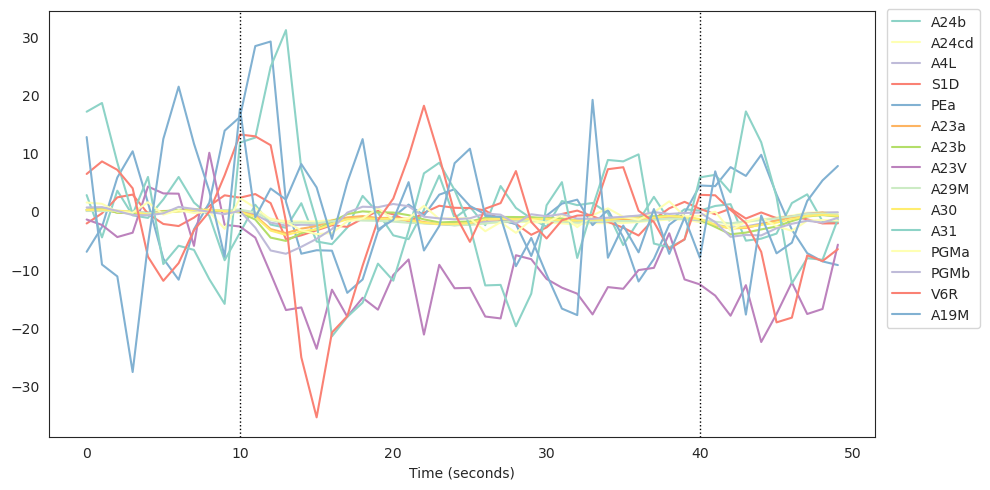

In [235]:
plt.figure(figsize=(10, 5))

# Plot each key's time series in a different color
for region, data in zip(cortical_ts_cleaned.keys(), mean_cortical_psth):
    plt.plot(data, label=cortical_atlas_labels[region])

# # Add vertical lines for each event
plt.axvline(x=10, color='black', linestyle='dotted', linewidth=1)
plt.axvline(x=10+30, color='black', linestyle='dotted', linewidth=1)

# Customize plot
plt.xlabel("Time (seconds)")
# plt.ylabel("Signal (e.g., Percent Signal Change)")
# plt.legend(loc='upper right')
# plt.title("Selected Cortical Regions Over Time with Event Markers")
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.005, 1.02))

# Show plot
plt.tight_layout()
# plt.savefig(os.path.join(figure_dir, 'selected_region_psth.svg'), dpi=300)
plt.show()

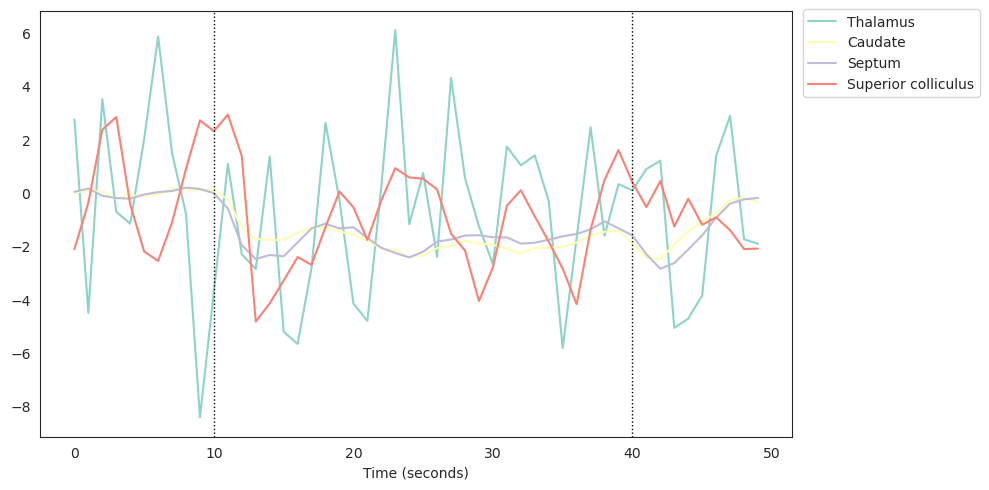

In [236]:
plt.figure(figsize=(10, 5))

# Plot each key's time series in a different color
for region, data in zip(subcortical_ts_cleaned.keys(), mean_cortical_psth):
    plt.plot(data, label=subcortical_atlas_labels[region])

# # Add vertical lines for each event
plt.axvline(x=10, color='black', linestyle='dotted', linewidth=1)
plt.axvline(x=10+30, color='black', linestyle='dotted', linewidth=1)

# Customize plot
plt.xlabel("Time (seconds)")
# plt.ylabel("Signal (e.g., Percent Signal Change)")
# plt.legend(loc='upper right')
# plt.title("Selected Cortical Regions Over Time with Event Markers")
# plt.grid(True)
plt.legend(bbox_to_anchor=(1.005, 1.02))

# Show plot
plt.tight_layout()
# plt.savefig(os.path.join(figure_dir, 'selected_region_psth.svg'), dpi=300)
plt.show()